### Question 6: Time series of daily SSTs and winds

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

#### Reproducing Figure 3b:

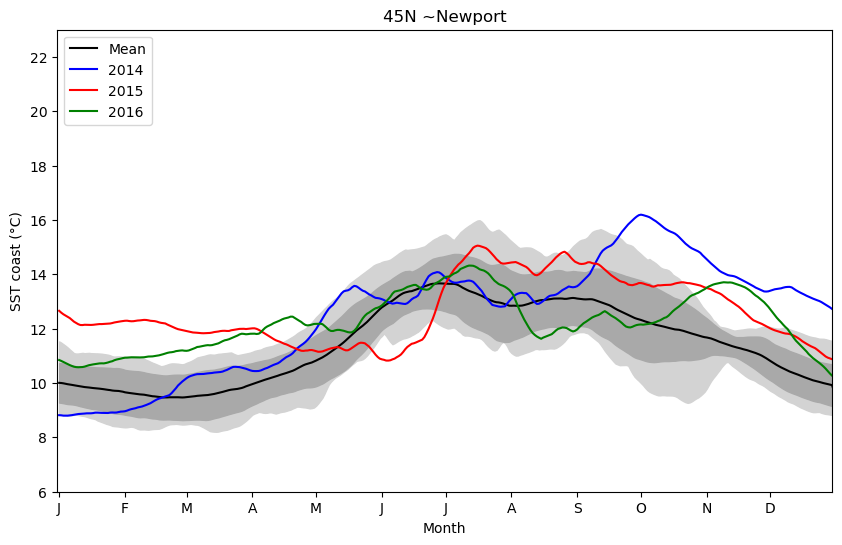

In [6]:
# slice data for the Newport given in matlab code and convert to Celsius
newport = ds.analysed_sst.sel(lat = 44.634, lon = -124.061, method = 'nearest') - 273.15

# take rolling mean
newport = newport.rolling(time = 30, center = True).mean()

# slice year 2002-2013 and grouped
ds2002 = newport.sel(time = slice('2002', '2013')).groupby('time.dayofyear')

# get max, min, mean, std, and upper/lower bounds
maximum = ds2002.max()
minimum = ds2002.min()
mean = ds2002.mean()
std = ds2002.std()
upper = mean + std
lower = mean - std

# create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# plot mean data from 2002-2013
ax.plot(mean.dayofyear.values, mean, 'k', label='Mean')

# plot shaded areas for maximum and minimum 
ax.fill_between(mean.dayofyear.values, minimum, maximum, color='lightgray')

# plot shaded area between lower and upper bound
ax.fill_between(mean.dayofyear.values, lower, upper, color='darkgray')

# plot smoothed time series for 2014, 2015, and 2016
ds2014 = newport.sel(time = '2014').groupby('time.dayofyear').mean().plot(x = 'dayofyear', color = 'b', label = '2014')
ds2015 = newport.sel(time = '2015').groupby('time.dayofyear').mean().plot(x = 'dayofyear', color = 'r', label = '2015')
ds2016 = newport.sel(time = '2016').groupby('time.dayofyear').mean().plot(x = 'dayofyear', color = 'g', label = '2016')

# labeling x-axis with months
plt.xticks([1, 32, 61, 92, 122, 153, 183, 214, 245, 275, 306, 336], 
           ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])  

ax.legend(loc = 'upper left')
plt.ylim(6, 23)
plt.xlim(0, 365)
plt.ylabel('SST coast (°C)')
plt.xlabel('Month')
plt.title('45N ~Newport')
plt.show()

The plot shows time series of daily SSTs and winds, smoothed with a 30 day running mean, in the northern part of the CCUS (Newport), SST 1 km offshore. 

The mean during 2002–2013 is shown in black, values between the maximum and minimum values during 2002–2013 are shown in light gray, values between ±1 SD around the mean during 2002–2013 are shown in dark gray, and blue, red, and green lines depict the values during 2014, 2015, and 2016, respectively. Values  outside the dark gray envelope are anomalies >1 SD from the mean.